# Intro

Supervised machine learning focuses on making accurate predictions. But we influence the world through decisions, not predictions. Predictions can be useful inputs to improve decision-making, but models that effectively optimized actions will be more valuable than those that only make predictions.

Reinforcement learning (RL) directly optimizes decision-making, but the RL community has primarily focused on problems (e.g. robotics and video games) that are very different from where most businesses are applying data science. 

This notebook illustrates a workflow I believe is appropriate for creating optimal decisions to today's mainstream business problems. In this workflow, the practitioner encodes domain knowledge into a structural model (the name being derived from the field of Structural Econometrics). The structural model includes multiple equations to describe different parts of the business problem, and it explicitly describes temporal dynamics.

The workflow is:
1. Use domain knowledge to specify a structural model describing a business problem.
2. Use pre-existing data to estimate unknown parts or parameters of the structural model
3. Treat the estimated model as a simulation environment, and use conventional optimization techniques to optimize the decision policy in the simulator
4. Apply that decision policy to make optimized decisions in the real business environment

> This workflow differs from model-based reinforcement learning, because it doesn't update the model of the environment during policy optimization. Instead, my workflow is similar to [World Models](https://arxiv.org/abs/1803.10122). My approach differs from World Models by having a human specify the structural model rather than deriving directly from a complex deep learning model. World Models uses video games as a testbed, and my approach would fail in that application because humans have little intuition in the pixel space. But human knowledge is beneficial as a regularizer in domains where we have good intuition.

# Example Use Cases

### Airline Pricing
Airlines already use machine learning models to help set ticket prices. The ML model predicts how many tickets the airline can sell each day for each upcoming flight for each candidate price. The models consider price, seasonablity, competitor prices, macroeconomic variables, etc. But even a perfect predictive model doesn't guarantee efficient price setting.

For example, consider a flight happening in 100 days which currently has 150 unsold seats. A predictive model says you can sell 1 ticket today for \\$300 or you could sell 2 tickets if you set the price at $250. Which price should you choose? 

Airlines currently convert predictive models into pricing decisions with heuristics (e.g. a timetable of how many tickets to sell at pre-specified periods before the flight, or a goal of selling up to a pre-specified demand elasticity.)

I believe formal optimization promises a major improvement over these rule-of-thumb approaches.

### Grocery Store Logistics
A grocery chain ran a [predictive modeling competition on Kaggle](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) to improve demand forecasts. They aimed to stock match their purchases from wholesales to their retail sales. However, the predicted sales is not always the optimal amount to stock.

If you purchase exactly the amount you are predicted to sell, you will experience frequent stockouts (when your model underestimates demand), reducing sales volume and disappointing customers.  Similarly, some items will spoil when predicted sales exceed actual sales. Unless the model is exactly correct every time, you face a tradeoff.  The optimal decision would consider factors like
- Markup rate on each item
- Spoilage rate
- Cost of storage
- Value of ensuring customers find the items they want
- etc.

In practice, grocery store managers likely guess at how to make these tradeoffs, much as they may have guessed at how much of each food they would sell before adopting ML. But the approach in this notebook would help them make better decisions.


# Implemention Overview
This notebook focuses on the Airline Pricing example. Specifically, I train an agent to set prices for Jetblue. The competitor, whose prices we cannot control, is called Delta. 

To illustrate the how resulting pricing policies perform in the original data generating environment, I use a simulation for the data generating process rather than using real data. Though I take a fixed dataset for trainng the predictive model in the conventional way. For illustrative simplicity, this example considers a market with only two airlines.

# The Tale of Two Models (and How They Plug Together)

I use two models:
A **structural model** defines workings of the market that a domain expert can specify. The structural model used in this example is straightforward. 

Each flight starts with a fixed number of available seats and a fixed number of days to departure. 

Each day until the flight happens
- airlines can update the ticket price daily
- the number of seats available decreases by the number of seats that airline sells
- the number of days until the flight decreases by 1
- accumulated revenue for the flight increases by `ticket_price * seats_sold`
- airlines cannot sell more seats than the plane has, and sales stop when the plane takes off (this model ignores overbooking, though someone more knowledgeable might add it to the model)

[This code](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/market.py#L45) shows this logic more concretely.

The **predictive model** captures things the airline doesn't know with any certainty:
- How their competitor sets prices
- How many seats each airline will sell on each day (as a function of daily demand shocks and each airline's price)

The predictive model used here is a [deep learning model](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/keras_models.py#L22). The structural model is completely deterministic once it receives the predictions from the predictive model.

> Aside: Structural econometrics has historically incorporated all uncertainty into the structural model, and not used a separate predictive model. This requires specifying all functional forms in the model and estimating those parameters directly (e.g. with maximum likelihood estimation). That workflow has the shortcomings of standard GLM style modeling ((poor predictive accuracy due to underfitting). Abstracting the sources of uncertainty into a separate predictive model allows the flexibility to use modern ML.

> Second Aside: I explored representing the structural and predictive models together using PyMC3. This allow estimating full Bayesian posteriors. This has a potentially large benefit for decision optimization (related to Jensen's inequality). I found it difficult to simulate market dynamics in PyMC3. I'll revisit this, likely after the release of PyMC4.

The code captures the two models in two objects:
- A `CompetitiveConditions` object contains the predictive model. It captures pricing strategies and the process for determining how many tickets are sold. When generating training data, the `CompetitiveConditions` object holds the true data generating process for pricing and quantity determination (rather than a predictive model). The data generating is unlike the predictive models that approximate it. Details of the data generating process for price and quantity determination aren't central to my workflow, so their description is saved for the end of this notebook.

- A `Market` object contains the logic for the structural model. The `market` object takes `CompetitiveConditions` as an argument, so predictions about market dynamics can be plugged into the structural model.

`Market` follows the standard OpenAI Gym API, so standard RL tools can be used to optimize pricing policies in our model based environment.

# Step 1: Collect Data From Real Market

I define parameters and import a function that determine the true data generating process. The exact market mechanisms (which the constants below affect) aren't central to explaining my workflow. So the description of market mechanics is postponed to the bottom of this notebook.

For now, you can treat the quantity-determining mechanism and it's parameters as a black box, much as the airlines do.

In [1]:
import numpy as np
import pandas as pd

from sem_policy_opt.true_dgp import get_true_qty_demanded_fn


# Constants hidden from airlines
CUSTOMER_LEVEL_RANDOMNESS = 20
DEMAND_SIGNAL_NOISINESS = 10
MAX_DEMAND_LEVEL = 400
POTENTIAL_CUSTOMERS_PER_DAY = 20

# Constants known to airlines
SEATS_PER_FLIGHT = 250
SALES_WINDOW_LENGTH = 120


I used trial and error to find a reasonable pricing function. I use the following function for both airlines when creating "real" data.

In [2]:
def simple_price_fn(my_demand_signal, days_before_flight, my_seats_avail, competitor_full): 
    # Charge more if you have a lot of time to sell seats, if few seats are available, or if you have little competition
    # On net, prices may increase over time because low seat inventory overwhelms remaining time effect.
    formula_price = 50 + my_demand_signal + 0.6 * days_before_flight - my_seats_avail + 40 * int(competitor_full)
    # demand_signal is noisy and can thus be negative. Never price tickets below some price_floor
    price_floor = 10
    actual_price = max(formula_price, price_floor)
    return actual_price


# Run Real Market

Airlines have historical data they can use to build a model. Here, I run the "real" environment to create this training data.

In [3]:
from sem_policy_opt.market import Market
from sem_policy_opt.market_conditions import CompetitiveConditions
from sem_policy_opt.diagnostics import run_env

real_market_conditions = CompetitiveConditions(delta_price_fn = simple_price_fn, 
                                               qty_fn=get_true_qty_demanded_fn(POTENTIAL_CUSTOMERS_PER_DAY, CUSTOMER_LEVEL_RANDOMNESS))

real_market = Market(real_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH) 

train_profits, train_data = run_env(real_market, simple_price_fn, n_times=1000)
val_profits, val_data = run_env(real_market, simple_price_fn, n_times=50)

# Step 2: Fit Predictive Model on Real Data

We fit a model that predicts Delta's price and the quantity sold as a function of
- Days remaining
- Jetblue's demand signal
- Jetblue's remaining number of seats available
- Whether Delta's flight is fully booked (i.e. whether Delta is still selling tickets)


In [4]:
from sem_policy_opt.keras_models import get_keras_model, prep_for_keras_model
from sem_policy_opt.diagnostics import r_squared

train_x, train_y = prep_for_keras_model(train_data)
val_x, val_y = prep_for_keras_model(val_data)
predictive_model = get_keras_model(train_x, train_y, val_x, val_y, verbose=0)

print(r_squared(predictive_model, val_data))

{'delta_price_r2': 0.9702370886539936, 'jb_qty_sold_r2': 0.6970092486311491, 'delta_qty_sold_r2': 0.6613003122270696}


# Step 3: Set Up Model-Based Market Simulator

I create a market based not on the true data generating processes (which the Jetblue doesn't know), but instead based on the predictive model.

In [5]:
sim_market_conditions = CompetitiveConditions(predictive_model=predictive_model)


As a diagnostic, I compare predicted profits from using Jetblue's current pricing function in the training, validation and simulator data.

In [6]:
# use function returning simulated market with baselines API to facilitate parallelism
sim_market_maker = lambda: Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)
noisy_sim_market_maker = lambda: Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH, summarize_on_episode_end=True)
sim_market = sim_market_maker()


simple_price_sim_profits, simple_price_sim_data = run_env(sim_market, simple_price_fn, n_times=50)

print("Mean profits in training data: {} \n"
      "Mean profits in val data: {} \n"
      "Mean profits in sim data: {} \n".format(train_profits.mean(), val_profits.mean(), simple_price_sim_profits.mean()))

Mean profits in training data: 42476.361600000004 
Mean profits in val data: 41981.804000000004 
Mean profits in sim data: 45069.924000000006 



# Step 4: Experiment With Different Pricing Strategies

We can use the simulator to test he performance of an arbitrary pricing function.

As a simple experiemnt, I first estimate revenue per flight with alternative pricing functions, each of which modifies the previous pricing function by multiplying prices by some `base_price_multiplier`.

For example a `base_price_multiplier` of 0.75 would correspond to discounting all prices by 25% from their previous pricing policy.

Results shown below

In [7]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

from sem_policy_opt.diagnostics import test_pricing_multipliers

price_comparison = test_pricing_multipliers(simple_price_fn, np.linspace(0.5, 1.5, 5), sim_market, real_market)

print(price_comparison)
price_comparison.plot.scatter(x='mean_predicted_rev', y='mean_actual_rev', c='base_price_mult', colormap='viridis')
plt.show()

   base_price_mult  mean_predicted_rev  mean_actual_rev
0             0.50          23675.0300       29320.6500
1             0.75          37292.4675       46219.8675
2             1.00          44838.1700       41961.9400
3             1.25          31039.4875       19768.4375
4             1.50          21784.7850       13319.2650


<Figure size 640x480 with 2 Axes>

Predicted revenue per flight is reasonable close to the actual revenue for flight when the multipliers is close to 1. Predictions become less accurate as we move further from the pricing policy used in the training data.

This is a limitation of the predictive model, rather than a shortcoming of the structural model. It's unsurprising that the predictive model is inaccurate for inputs that are far from what occurred in the training data.

To see the shortcoming in the predictive model, consider the demand curve shown below. Here, I predict quantities sold in a given day for various candidate jetblue prices (holding the number of days until the flight and Jetblue's demand signal constant.)

In [8]:
days_before_flight = jb_demand_signal = 100
pred_outcomes_diff_jb_prices = []
for jb_price in np.linspace(0, MAX_DEMAND_LEVEL, 6):
    # Some extra munging here do to messiness associated with multi-input / multi-output model.
    # each input fed in as separate array to facilitate hiding jetblue_price from prediction of delta_price
    prediction_data = prep_for_keras_model([days_before_flight, jb_demand_signal, jb_price], skip_y=True)
    prediction = predictive_model.predict(prediction_data)
    delta_price, jb_seats_sold, delta_seats_sold = [i[0][0] for i in prediction]
    pred_outcomes_diff_jb_prices.append({'jb_price': jb_price,
                                         'delta_price': delta_price,
                                         'jetblue_seats_sold': jb_seats_sold,
                                         'delta_seats_sold': delta_seats_sold})
pd.DataFrame(pred_outcomes_diff_jb_prices).set_index(['jb_price'])

,delta_price,delta_seats_sold,jetblue_seats_sold
jb_price,,,
0.0,93.636215,4.692324,9.627397
80.0,93.636215,6.995571,8.111498
160.0,93.636215,1.338803,0.517717
240.0,93.636215,0.988530,0.131826
320.0,93.636215,0.358300,0.052600
400.0,93.636215,0.018477,0.010047


It's reassuring that delta price is independent of **jb_price**. As a rule of the environment, Delta chooses a price before seeing Jetblue's.  However, it's a shortcoming of the model that Delta's quantity sold doesn't monotonically increase with Jetblue's price.

Even with an imperfect model, pricing policy optimization can work very well, and an optimized policy would yield far greater profits in the real environment.

# Step 4: Optimize Policy Function
We could use an arbitrary optimization procedure to optimize our policy. The appendix contains a Soft Actor Critic approach, and I may experiment with other approaches in the future. For now, I use a simple grid search. Pricing policies are created as linear functions of the state variables
- Daily demand signal
- Days remaining before flight
- Seats available
- Whether the competitor's flight is full

I try various multipliers of these state variables. The pricing equation is specified more precisely [here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/diagnostics.py#L9).

The optimization code is below.

In [21]:
from collections import OrderedDict
from itertools import product
from time import time
from sem_policy_opt.diagnostics import pricing_fn_creator

optim_results = []
intercepts = np.linspace(0, 200, 4)
demand_signal_mults = np.linspace(0, 1, 4)
days_before_flight_mults = np.linspace(0, 1, 4)
seats_avail_mults = np.linspace(-1, 0, 4)
competitor_full_mults = np.linspace(0, 100, 4)
price_floors = np.array([0, 50])

pricing_combinations = product(intercepts, demand_signal_mults, days_before_flight_mults, 
                               seats_avail_mults, competitor_full_mults, price_floors)    

optim_start_time = time()
for params in pricing_combinations:
    pricing_fn = pricing_fn_creator(*params)
    mean_sim_reward = run_env(sim_market, pricing_fn, n_times=5)[0].mean()
    mean_real_reward = run_env(real_market, pricing_fn, n_times=5)[0].mean()

    optim_results.append(OrderedDict(intercept=params[0],
                                     demand_signal_mult=params[1],
                                     days_before_flight_mult=params[2],
                                     seats_avail_mult=params[3],
                                     competitor_full_mult=params[4],
                                     price_floor=params[5],
                                     sim_profit=mean_sim_reward,
                                     real_profit=mean_real_reward))
    
optim_results_df = pd.DataFrame(optim_results)
print("Optimation time: {}".format(int(time()-optim_start_time)))

Optimation time: 129


A firm would select the policy that returns the highest predicted profit in simulation (since simulation is all they can see before implementing a new policy). This process is effective to the extent the policy generates higher profits in the true market environment. Predicted and real profits from various policies are shown in the following graph.

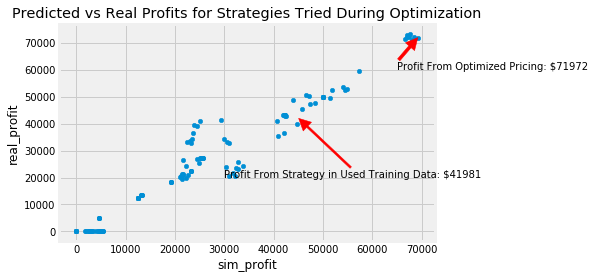

In [22]:
from sem_policy_opt.diagnostics import plot_optim_results


plot_optim_results(optim_results_df, 
                   baseline_real_profits=val_profits.mean(), 
                   baseline_sim_profits=simple_price_sim_profits.mean())

The pricing parameters yielding the highest profits were:

In [23]:
max_sim_profit = max(optim_results_df.sim_profit)
optim_results_df.query('sim_profit == @max_sim_profit')

,intercept,demand_signal_mult,days_before_flight_mult,seats_avail_mult,competitor_full_mult,price_floor,sim_profit,real_profit
94,200.0,0.0,1.0,0.0,100.0,0,69218.6,71972.2


Price optimization nearly doubled real profits in this example. 

In practice, airlines must have better pricing strategies than the baseline I found through the trial and error experimentation.  On the other hand, even a 1% increase in revenue would be a big win. 

The two greatest shortcomings of this example are:
1. This market is simplified in important ways. There is only one competitor. There are fewer moving parts like seasonality that affect demand (though the effect of seasonality could be estimated and plugged into this example in a straightforward way)
2. Firms likely won't implement an important policy without evidence it works. This example simulates the real environment to provide that evidence in this use case, but it's unclear how to make this workflow compelling without that.

I'm interested in others' reactions so I can add to this list (and hopefully address some shortcomings).

Despite these shortcomings, this notebook demonstrates an optimization workflow that I believe adds as values on the same order of magnitude as what most organizations will gain from applying supervised ML without optimization.

# Appendix

#### How The Market In This Example Works
Some number of customers (`POTENTIAL_CUSTOMERS_PER_DAY`) come to a website each day.  The customers' average willingness to pay for a flight on that day `demand_level`. The `demand level` on any given day is chosen from a distribution `uniform(0, MAX_DEMAND_LEVEL)`.  Each airline receives a signal about `demand_level` on that day, and the signal is the `demand_level` plus some noise that is distributed `N(0, DEMAND_SIGNAL_NOISINESS)`. This demand signal might represent a prediction of demand from a model considering seasonality, macroeconomics, etc. Additionally, each customer has idiosyncratic preferences, so their willingness to pay for a ticket on any given airline is `demand_level + customer_preference` where `customer_preference` is distributed `N(0, CUSTOMER_LEVEL_RANDOMNESS)`.  The customer considers the price for each of the two airlines and purchases a ticket from the airline that gives them the highest consumer surplus (their personal willingness to pay minus for a ticket on that airline minus the cost of a ticket on that airline).  If the customer's consumer surplus for both airlines is negative, they do not buy a ticket.

#### Optimization Through Modern Reinforcement Learning

The cell below optimizes the pricing policy through Soft Actor Critic (SAC), an RL algorithm that is sample efficient and which is reported to require little hyperparameter tuning.

An initial run of SAC shows worse results than the simple grid search ("worse" at optimizing in the simulation environment). This implementation of SAC requires the action space be symmetric, so negative prices are allowed. Oddly, SAC sometimes chooses negative prices. Further exploration could be interesting, but grid-search shows the promise of my larger approach even with very basic optimization techniques.

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.sac.policies import MlpPolicy
from stable_baselines.sac import SAC
from time import time
import os

parallelism_level = 1         # use os.cpu_count() if not using SAC. SAC doesn't allow parallelism
env = DummyVecEnv([sim_market_maker for _ in range(parallelism_level)]) # Env is vectorized market for parallelism
total_learning_steps = 750000
steps_per_update = 10000
optim_results = []

model = SAC(MlpPolicy, env)

start_time = time()
for step in range(0, total_learning_steps+1, steps_per_update):
    model.learn(total_timesteps=steps_per_update)
    
    mean_sim_reward = run_env(sim_market, model, n_times=5)[0].mean()
    mean_real_reward = run_env(real_market, model, n_times=5)[0].mean()
    optim_results.append(dict(step=step, 
                              time=time()-start_time,
                              sim_profit=mean_sim_reward,
                              real_profit=mean_real_reward))
    
    print("""{} timesteps used for learning in {:.0f} seconds. 
             Current score in sim: {:.0f}. Current score in real market: {:.0f}.""".format(
                                                                                step,
                                                                                time()-start_time, 
                                                                                mean_sim_reward, 
                                                                                mean_real_reward))
optim_results_df = pd.DataFrame(optim_results)
optim_results_df.plot.line(x='step', y=['sim_profit', 'real_profit'])